In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

import pickle as pkl
import pandas as pd
import os
import requests as r
from sklearn.metrics import accuracy_score
import random

np.random.seed(37)

random.seed(1254)

tf.random.set_seed(89)


gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

script_name = 'Scratch-AFAD-Full-Age-R50-MultiOutput'



In [2]:
def encode(data, mask):
    labels = []
    for item in data:
        labels.append(mask[item])
    return labels

In [3]:
csv_target_train = 'AFAD-Full/train.csv'
df_train = pd.read_csv(csv_target_train)

bins = [0, 3, 10, 20, 30, 40, 50, 60, 70, np.inf]
names = ['0-2', '3-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70+']

df_train['age'] = pd.cut(df_train['age_abs'], bins, labels=names)


In [4]:
df_train

,file,gender,age_abs,age
0,23/112/190424-1.jpg,Female,23,20-29
1,27/111/139620-0.jpg,Male,27,20-29
2,36/111/306718-2.jpg,Male,36,30-39
3,38/111/579575-0.jpg,Male,38,30-39
4,20/111/195051-0.jpg,Male,20,10-19
...,...,...,...,...
165496,20/112/108659-0.jpg,Female,20,10-19
165497,36/111/482001-1.jpg,Male,36,30-39
165498,19/111/42720-0.jpg,Male,19,10-19
165499,24/111/161789-0.jpg,Male,24,20-29


In [5]:
def label2dict(df):
    values = df.unique()
    d = {}
    for idx, v in enumerate(values):
        d[v] = idx
    return d
def apply_encode(map_dict, col, row):
    return map_dict[row[col]]

In [6]:
target_col = ['gender', 'age']
num_classes = []
for col in target_col:
    num_classes.append(df_train[col].nunique())
input_shape = (112, 112, 3)
batch_size = 64
learning_rate = 0.001
hidden_units = 512
projection_units = 128
num_epochs = 50
dropout_rate = 0.5
temperature = 0.05
validation_split = 0.2

In [7]:
target_col_data = []
for col in target_col:
    col2 = col + '_sparse'
    target_col_data.append(col2)
    map_dict = label2dict(df_train[col])
    df_train[col2] = df_train.apply(lambda row: apply_encode(map_dict, col, row), axis=1)

In [8]:
x_col = 'file'
y_col = target_col_data
from tensorflow.keras.applications.resnet50 import preprocess_input
train_generator = keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=validation_split
)
val_generator = keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_iter = train_generator.flow_from_dataframe(
    df_train,
    directory='./AFAD-Full',
    x_col=x_col,
    y_col=y_col,
    class_mode="multi_output",
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    subset='training'
)

val_iter = train_generator.flow_from_dataframe(
    df_train,
    directory='./AFAD-Full',
    x_col=x_col,
    y_col=y_col,
    class_mode="multi_output",
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    subset='validation'
)

Found 132401 validated image filenames.
Found 33100 validated image filenames.


In [9]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.02),
        layers.experimental.preprocessing.RandomWidth(0.2),
        layers.experimental.preprocessing.RandomHeight(0.2),
    ]
)

In [10]:
callbacks = []
for col in target_col:
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath='./ckpt/{}-{}.h5'.format(script_name, col),
        monitor='val_{}_sparse_categorical_accuracy'.format(col),
        mode='max',
        save_best_only=True)
    callbacks.append(model_checkpoint_callback)

In [11]:
def create_encoder():
    resnet = keras.applications.ResNet50V2(
        include_top=False, weights=None, input_shape=input_shape, pooling="avg"
    )

    inputs = keras.Input(shape=input_shape)
    augmented = data_augmentation(inputs)
    outputs = resnet(augmented)
    model = keras.Model(inputs=inputs, outputs=outputs, name="encoder")
    return model


encoder = create_encoder()
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 112, 112, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, None, None, 3)     0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 2048)              23564800  
Total params: 23,564,800
Trainable params: 23,519,360
Non-trainable params: 45,440
_________________________________________________________________


In [12]:
def create_classifier(encoder, trainable=True, training=True):

    encoder.trainable = trainable

    inputs = keras.Input(shape=input_shape, name="input")
    features = encoder(inputs, training=training)
    outputs = []
    for idx, num_class in enumerate(num_classes):
        _features = layers.Dropout(dropout_rate, name="dropout_" + target_col[idx])(features)
        _features = layers.Dense(hidden_units, activation="relu", name = "features"+ target_col[idx])(_features)
        _features = layers.Dropout(dropout_rate, name="dropout2_" + target_col[idx])(_features)
        outputs.append(layers.Dense(num_class, activation="softmax", name=target_col[idx])(_features))

    model = keras.Model(inputs=inputs, outputs=outputs, name="classifier")
    metrics = {}
    loss = []
    for col in target_col:
        metrics[col] = keras.metrics.SparseCategoricalAccuracy()
        loss.append(keras.losses.SparseCategoricalCrossentropy())
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=loss,
        metrics=metrics
    )
    return model

In [13]:
encoder = create_encoder()
classifier = create_classifier(encoder)
classifier.summary()

Model: "classifier"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 112, 112, 3) 0                                            
__________________________________________________________________________________________________
encoder (Functional)            (None, 2048)         23564800    input[0][0]                      
__________________________________________________________________________________________________
dropout_gender (Dropout)        (None, 2048)         0           encoder[0][0]                    
__________________________________________________________________________________________________
dropout_age (Dropout)           (None, 2048)         0           encoder[0][0]                    
_________________________________________________________________________________________

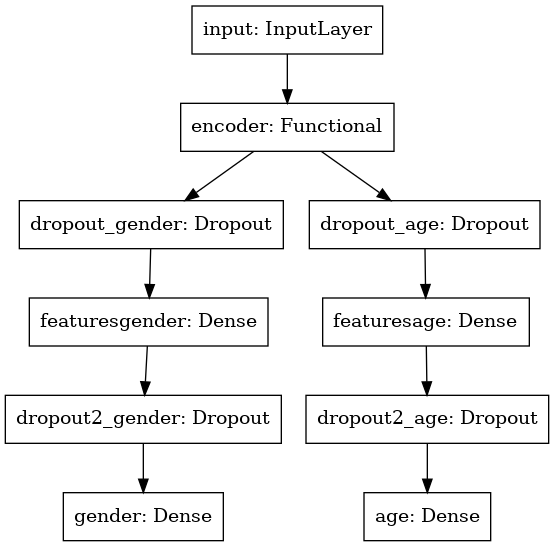

In [14]:
keras.utils.plot_model(classifier)

In [15]:
history = classifier.fit(train_iter, batch_size=batch_size, epochs=num_epochs, validation_data=val_iter, callbacks=callbacks)


Epoch 1/50
2069/2069 [==============================] - 221s 103ms/step - loss: 1.3421 - gender_loss: 0.3139 - age_loss: 1.0282 - gender_sparse_categorical_accuracy: 0.8641 - age_sparse_categorical_accuracy: 0.5413 - val_loss: 1.1714 - val_gender_loss: 0.1917 - val_age_loss: 0.9797 - val_gender_sparse_categorical_accuracy: 0.9234 - val_age_sparse_categorical_accuracy: 0.5511


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
2069/2069 [==============================] - 177s 85ms/step - loss: 1.1366 - gender_loss: 0.1782 - age_loss: 0.9584 - gender_sparse_categorical_accuracy: 0.9311 - age_sparse_categorical_accuracy: 0.5607 - val_loss: 1.0821 - val_gender_loss: 0.1589 - val_age_loss: 0.9232 - val_gender_sparse_categorical_accuracy: 0.9399 - val_age_sparse_categorical_accuracy: 0.5755
Epoch 3/50
2069/2069 [==============================] - 173s 83ms/step - loss: 1.0782 - gender_loss: 0.1518 - age_loss: 0.9264 - gender_sparse_categorical_accuracy: 0.9431 - age_sparse_categorical_accuracy: 0.5751 - val_loss: 1.0557 - val_gender_loss: 0.1503 - val_age_loss: 0.9054 - val_gender_sparse_categorical_accuracy: 0.9408 - val_age_sparse_categorical_accuracy: 0.5853
Epoch 4/50
2069/2069 [==============================] - 171s 83ms/step - loss: 1.0433 - gender_loss: 0.1375 - age_loss: 0.9059 - gender_sparse_categorical_accuracy: 0.9496 - age_sparse_categorical_accuracy: 0.5847 - val_loss: 1.0077 - val_gender_

2069/2069 [==============================] - 169s 82ms/step - loss: 0.8211 - gender_loss: 0.0627 - age_loss: 0.7584 - gender_sparse_categorical_accuracy: 0.9797 - age_sparse_categorical_accuracy: 0.6632 - val_loss: 0.8523 - val_gender_loss: 0.0719 - val_age_loss: 0.7805 - val_gender_sparse_categorical_accuracy: 0.9769 - val_age_sparse_categorical_accuracy: 0.6520
Epoch 24/50
2069/2069 [==============================] - 170s 82ms/step - loss: 0.8164 - gender_loss: 0.0624 - age_loss: 0.7539 - gender_sparse_categorical_accuracy: 0.9797 - age_sparse_categorical_accuracy: 0.6658 - val_loss: 0.8413 - val_gender_loss: 0.0749 - val_age_loss: 0.7664 - val_gender_sparse_categorical_accuracy: 0.9754 - val_age_sparse_categorical_accuracy: 0.6568
Epoch 25/50
2069/2069 [==============================] - 169s 82ms/step - loss: 0.8174 - gender_loss: 0.0634 - age_loss: 0.7540 - gender_sparse_categorical_accuracy: 0.9794 - age_sparse_categorical_accuracy: 0.6652 - val_loss: 0.8390 - val_gender_loss: 0.0

2069/2069 [==============================] - 170s 82ms/step - loss: 0.7390 - gender_loss: 0.0465 - age_loss: 0.6926 - gender_sparse_categorical_accuracy: 0.9853 - age_sparse_categorical_accuracy: 0.6969 - val_loss: 0.8325 - val_gender_loss: 0.0753 - val_age_loss: 0.7572 - val_gender_sparse_categorical_accuracy: 0.9770 - val_age_sparse_categorical_accuracy: 0.6679
Epoch 45/50
2069/2069 [==============================] - 170s 82ms/step - loss: 0.7365 - gender_loss: 0.0462 - age_loss: 0.6903 - gender_sparse_categorical_accuracy: 0.9858 - age_sparse_categorical_accuracy: 0.6993 - val_loss: 0.8360 - val_gender_loss: 0.0762 - val_age_loss: 0.7598 - val_gender_sparse_categorical_accuracy: 0.9783 - val_age_sparse_categorical_accuracy: 0.6645
Epoch 46/50
2069/2069 [==============================] - 170s 82ms/step - loss: 0.7360 - gender_loss: 0.0464 - age_loss: 0.6896 - gender_sparse_categorical_accuracy: 0.9852 - age_sparse_categorical_accuracy: 0.6989 - val_loss: 0.8475 - val_gender_loss: 0.0

<Response [200]>

In [16]:
classifier.save('./ckpt/{}-{}.h5'.format(script_name, 'last'))

In [17]:
class SupervisedContrastiveLoss(keras.losses.Loss):
    def __init__(self, temperature=1, name=None):
        super(SupervisedContrastiveLoss, self).__init__(name=name)
        self.temperature = temperature

    def __call__(self, labels, feature_vectors, sample_weight=None):
        # Normalize feature vectors
        feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)
        # Compute logits
        logits = tf.divide(
            tf.matmul(
                feature_vectors_normalized, tf.transpose(feature_vectors_normalized)
            ),
            self.temperature,
        )
        return tfa.losses.npairs_loss(tf.squeeze(labels), logits)


def add_projection_head(encoder):
    inputs = keras.Input(shape=input_shape)
    features = encoder(inputs)
    outputs = []
    for col in target_col:
        outputs.append(layers.Dense(projection_units, activation="relu", name="features_" + col)(features))
    model = keras.Model(
        inputs=inputs, outputs=outputs, name="encoder_with_projection-head"
    )
    return model

In [18]:
script_name = 'SupCon-AFAD-Full-Age-R50-MultiOutput'

Model: "encoder_with_projection-head"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 112, 112, 3) 0                                            
__________________________________________________________________________________________________
encoder (Functional)            (None, 2048)         23564800    input_7[0][0]                    
__________________________________________________________________________________________________
features_gender (Dense)         (None, 128)          262272      encoder[0][0]                    
__________________________________________________________________________________________________
features_age (Dense)            (None, 128)          262272      encoder[0][0]                    
Total params: 24,089,344
Trainable params: 24,043,904
Non-trainable par

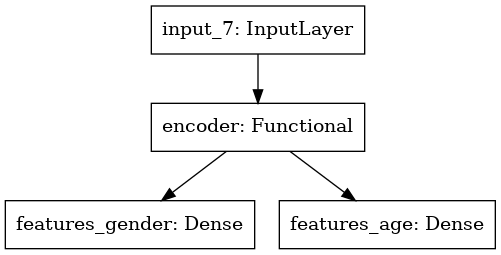

In [19]:
encoder = create_encoder()
loss = []
for col in target_col:
    loss.append(SupervisedContrastiveLoss(temperature))
encoder_with_projection_head = add_projection_head(encoder)
encoder_with_projection_head.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=loss,
)

encoder_with_projection_head.summary()
keras.utils.plot_model(encoder_with_projection_head)

In [20]:
history = encoder_with_projection_head.fit(
    train_iter, batch_size=batch_size, epochs=num_epochs
)


Epoch 1/50
2069/2069 [==============================] - 144s 68ms/step - loss: 8.0441 - features_gender_loss: 3.8907 - features_age_loss: 4.1534
Epoch 2/50
2069/2069 [==============================] - 139s 67ms/step - loss: 7.9195 - features_gender_loss: 3.7733 - features_age_loss: 4.1461
Epoch 3/50
2069/2069 [==============================] - 139s 67ms/step - loss: 7.8771 - features_gender_loss: 3.7369 - features_age_loss: 4.1402
Epoch 4/50
2069/2069 [==============================] - 139s 67ms/step - loss: 7.8484 - features_gender_loss: 3.7146 - features_age_loss: 4.1337
Epoch 5/50
2069/2069 [==============================] - 139s 67ms/step - loss: 7.8237 - features_gender_loss: 3.6974 - features_age_loss: 4.1263
Epoch 6/50
2069/2069 [==============================] - 140s 68ms/step - loss: 7.8022 - features_gender_loss: 3.6823 - features_age_loss: 4.1199
Epoch 7/50
2069/2069 [==============================] - 139s 67ms/step - loss: 7.7845 - features_gender_loss: 3.6704 - features_ag

<Response [200]>

In [21]:
callbacks = []
for col in target_col:
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath='./ckpt/{}-{}.h5'.format(script_name, col),
        monitor='val_{}_sparse_categorical_accuracy'.format(col),
        mode='max',
        save_best_only=True)
    callbacks.append(model_checkpoint_callback)

In [22]:
classifier = create_classifier(encoder, trainable=False, training=False)
classifier.summary()
history = classifier.fit(train_iter, batch_size=batch_size, epochs=10, validation_data=val_iter, callbacks=callbacks)

Model: "classifier"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 112, 112, 3) 0                                            
__________________________________________________________________________________________________
encoder (Functional)            (None, 2048)         23564800    input[0][0]                      
__________________________________________________________________________________________________
dropout_gender (Dropout)        (None, 2048)         0           encoder[1][0]                    
__________________________________________________________________________________________________
dropout_age (Dropout)           (None, 2048)         0           encoder[1][0]                    
_________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
2069/2069 [==============================] - 158s 76ms/step - loss: 0.7657 - gender_loss: 0.0351 - age_loss: 0.7306 - gender_sparse_categorical_accuracy: 0.9919 - age_sparse_categorical_accuracy: 0.6914 - val_loss: 0.8424 - val_gender_loss: 0.0741 - val_age_loss: 0.7682 - val_gender_sparse_categorical_accuracy: 0.9808 - val_age_sparse_categorical_accuracy: 0.6622
Epoch 3/10
2069/2069 [==============================] - 158s 76ms/step - loss: 0.7627 - gender_loss: 0.0345 - age_loss: 0.7282 - gender_sparse_categorical_accuracy: 0.9920 - age_sparse_categorical_accuracy: 0.6909 - val_loss: 0.8350 - val_gender_loss: 0.0730 - val_age_loss: 0.7620 - val_gender_sparse_categorical_accuracy: 0.9807 - val_age_sparse_categorical_accuracy: 0.6657
Epoch 4/10
2069/2069 [==============================] - 157s 76ms/step - loss: 0.7621 - gender_loss: 0.0342 - age_loss: 0.7279 - gender_sparse_categorical_accuracy: 0.9922 - age_sparse_categorical_accuracy: 0.6906 - val_loss: 0.8437 - val_gender_

<Response [200]>

In [23]:
classifier.trainable = True
classifier.summary()
history = classifier.fit(train_iter, batch_size=batch_size, epochs=40, initial_epoch=10, validation_data=val_iter, callbacks=callbacks)

Model: "classifier"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 112, 112, 3) 0                                            
__________________________________________________________________________________________________
encoder (Functional)            (None, 2048)         23564800    input[0][0]                      
__________________________________________________________________________________________________
dropout_gender (Dropout)        (None, 2048)         0           encoder[1][0]                    
__________________________________________________________________________________________________
dropout_age (Dropout)           (None, 2048)         0           encoder[1][0]                    
_________________________________________________________________________________________

2069/2069 [==============================] - 158s 77ms/step - loss: 0.7562 - gender_loss: 0.0332 - age_loss: 0.7230 - gender_sparse_categorical_accuracy: 0.9923 - age_sparse_categorical_accuracy: 0.6904 - val_loss: 0.8442 - val_gender_loss: 0.0775 - val_age_loss: 0.7667 - val_gender_sparse_categorical_accuracy: 0.9806 - val_age_sparse_categorical_accuracy: 0.6638
Epoch 27/40
2069/2069 [==============================] - 158s 76ms/step - loss: 0.7579 - gender_loss: 0.0332 - age_loss: 0.7247 - gender_sparse_categorical_accuracy: 0.9922 - age_sparse_categorical_accuracy: 0.6885 - val_loss: 0.8383 - val_gender_loss: 0.0787 - val_age_loss: 0.7596 - val_gender_sparse_categorical_accuracy: 0.9810 - val_age_sparse_categorical_accuracy: 0.6650
Epoch 28/40
2069/2069 [==============================] - 159s 77ms/step - loss: 0.7567 - gender_loss: 0.0330 - age_loss: 0.7236 - gender_sparse_categorical_accuracy: 0.9923 - age_sparse_categorical_accuracy: 0.6886 - val_loss: 0.8501 - val_gender_loss: 0.0

<Response [200]>

In [24]:
classifier.save('./ckpt/{}-{}.h5'.format(script_name, 'last'))

In [25]:
res = []
names = ['Scratch-AFAD-Full-Age-R50-MultiOutput-{}.h5', 'SupCon-AFAD-Full-Age-R50-MultiOutput-{}.h5']
for name in names:
    for col in target_col + ['last']:
        model_file = 'ckpt/' + name.format(col)
        model = keras.models.load_model(model_file)
        eval_res = model.evaluate(val_iter)
        eval_res = [name.format(col)] + eval_res
        res.append(eval_res)          
df_res = pd.DataFrame(res, columns = ['name', 'total_loss', 'gender_loss', 'age_loss', 'gender_acc', 'age_acc'])
df_res.to_csv('Compare - Scratch - SupCon - AFAD-Full.csv')

518/518 [==============================] - 33s 63ms/step - loss: 0.8401 - gender_loss: 0.0790 - age_loss: 0.7611 - gender_sparse_categorical_accuracy: 0.9809 - age_sparse_categorical_accuracy: 0.6637
